This notebook generates Supplementary Figure 11 in the Sei framework manuscript, showing the top 25 enriched Cistrome DB chromatin profiles for each sequence class. 

In [1]:
from collections import defaultdict
import glob
import os

import h5py
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests


In [2]:
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
RESOURCES_DIR = '../resources'
SEI_DIR = './sei_data'
FIGS_DIR = './figures'

In [4]:
SC_NAMES_FILE = os.path.join(RESOURCES_DIR, 'cnames.tsv')
df = pd.read_csv(SC_NAMES_FILE, sep='\t')
df.head()
MAPPING = {}
for row in df.itertuples():
    MAPPING[row.index] = '{0} {1}'.format(row.ID, row.name)

The enrichments are computed from the chromatin profile labels for 2 million random sequences.

In [5]:
enrichment_df = pd.read_csv(
    os.path.join(SEI_DIR, 'target_enrichments.aa.tsv'),
    sep='\t',
    index_col=0).T

In [6]:
profile_mapping = np.load(
    os.path.join(RESOURCES_DIR, 'sei_profiles_mapping.npy'),
    allow_pickle=True).item()


In [7]:
ix_profile = {ix: p for (ix, p) in enumerate(enrichment_df.columns)}
profile_ix = {p: ix for (ix, p) in enumerate(enrichment_df.columns)}

In [8]:
seqclass_or = []
seqclass_pvalues = []
for c in range(40):
    seqclass_or.append(np.load(
        os.path.join(
            SEI_DIR, 'fisher_exact', '{0}.oddsratio.npy'.format(c))))
    seqclass_pvalues.append(np.load(
        os.path.join(
            SEI_DIR, 'fisher_exact', '{0}.pvalues.npy'.format(c))))
seqclass_or = np.vstack(seqclass_or)
seqclass_pvalues = np.hstack(seqclass_pvalues)
_, seqclass_fdr, _, _ = multipletests(
    seqclass_pvalues, alpha=0.01, method='fdr_bh', is_sorted=False)
seqclass_fdr = seqclass_fdr.reshape((40, 21907))

In [9]:
FDR_THRESHOLD = 2.2e-16

significant_rows = []
full_seqclass_mat = []
for c, desc in MAPPING.items():
    fdrs = seqclass_fdr[c]
    enrichments = enrichment_df.iloc[c].values
    full_seqclass_mat.append(enrichments)
    
    # select chromatin profiles below FDR threshold
    ixs = np.where(fdrs < FDR_THRESHOLD)[0]  
    subset_enrichments = enrichments[ixs]
    sorted_ixs = np.argsort(-1*subset_enrichments)
    
    for ix in ixs[sorted_ixs]:
        significant_rows.append({
            'sequence_class': c,
            'sequence_class_name': desc,
            'chromatin_profile': ix_profile[ix],
            'logFC_enrichment': enrichments[ix],
            'pvalue': fdrs[ix]
        })

full_seqclass_mat = np.vstack(full_seqclass_mat)
sig_enrichment_df = pd.DataFrame.from_dict(significant_rows)
sig_enrichment_df.head()

,sequence_class,sequence_class_name,chromatin_profile,logFC_enrichment,pvalue
0,12,E5 B-cell-like,GM19201_Lymphoblastoid | H3K4me1 | ID:54938,4.582872,0.000000e+00
1,12,E5 B-cell-like,GM12878_B_Lymphocyte_Blood | EP300 | ID:47885,4.582367,0.000000e+00
2,12,E5 B-cell-like,GM12878_B_Lymphocyte_Blood | RELA | ID:4969,4.549074,0.000000e+00
3,12,E5 B-cell-like,GM12878_B_Lymphocyte_Blood | EP300 | ID:47884,4.547713,0.000000e+00
4,12,E5 B-cell-like,GM18951_Lymphoblastoid_Blood | RELA | ID:4964,4.527211,1.122984e-243


In [10]:
sig_enrichment_df.to_csv(
    os.path.join(SEI_DIR, 'significant_chromatin_profiles.fishers.tsv'),
    sep='\t')

In [11]:
TOP_N_PROFILES = 25

use_rows = []
use_rowlabels = []
for c, desc in MAPPING.items():
    sc_rows = sig_enrichment_df[
        sig_enrichment_df['sequence_class'] == c]
    for ix, row in enumerate(sc_rows.itertuples()):
        if ix > TOP_N_PROFILES:
            break
        use_rows.append(profile_ix[row.chromatin_profile])
        use_rowlabels.append(row.chromatin_profile)


In [12]:
enrichment_mat = full_seqclass_mat[:, use_rows]
    
data_df = pd.DataFrame(enrichment_mat.T)
data_df.rename(index={
    l: use_rowlabels[i] 
       for (i, l) in enumerate(data_df.index.tolist())}, inplace=True)
data_df.columns = MAPPING.values()
data_df.head()

,E5 B-cell-like,E7 Monocyte / Macrophage,E11 T-cell,E12 Erythroblast-like,E1 Stem cell,E10 Brain,E3 Brain / Melanocyte,E9 Liver / Intestine,E2 Multi-tissue,E4 Multi-tissue,...,TF2 CEBPB,TF4 OTX2,TF1 NANOG / FOXA1,L3 Low signal,L4 Low signal,L5 Low signal,L6 Low signal,L7 Low signal,L1 Low signal,L2 Low signal
GM19201_Lymphoblastoid | H3K4me1 | ID:54938,4.582872,-0.428942,-1.744266,-2.008476,-4.311936,-3.913906,-inf,-4.400717,-2.728250,1.262412,...,-5.031654,-inf,-inf,-inf,-inf,-0.795545,-inf,-inf,-inf,-inf
GM12878_B_Lymphocyte_Blood | EP300 | ID:47885,4.582367,-0.696875,0.756475,-1.922772,-3.226233,-inf,-4.196590,-inf,-4.227509,1.232639,...,-inf,-inf,-inf,-inf,-inf,-2.031769,-inf,-inf,-inf,-inf
GM12878_B_Lymphocyte_Blood | RELA | ID:4969,4.549074,-0.784954,-0.161679,-inf,-3.951742,-inf,-3.922099,-inf,-4.953018,1.507129,...,-3.671459,-inf,-inf,-inf,-inf,-0.757278,-inf,-inf,-inf,-4.994926
GM12878_B_Lymphocyte_Blood | EP300 | ID:47884,4.547713,-0.259542,0.430847,-2.707832,-2.426330,-inf,-4.981650,-inf,-4.012569,1.322048,...,-4.731010,-inf,-inf,-inf,-inf,-1.594436,-inf,-inf,-inf,-5.054477
GM18951_Lymphoblastoid_Blood | RELA | ID:4964,4.527211,-0.156624,-0.340704,-inf,-inf,-inf,-inf,-inf,-inf,1.386998,...,-3.043129,-inf,-inf,-inf,-inf,-1.713911,-inf,-inf,-inf,-inf


/mnt/home/kchen/anaconda3/envs/sei-manu/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  import sys


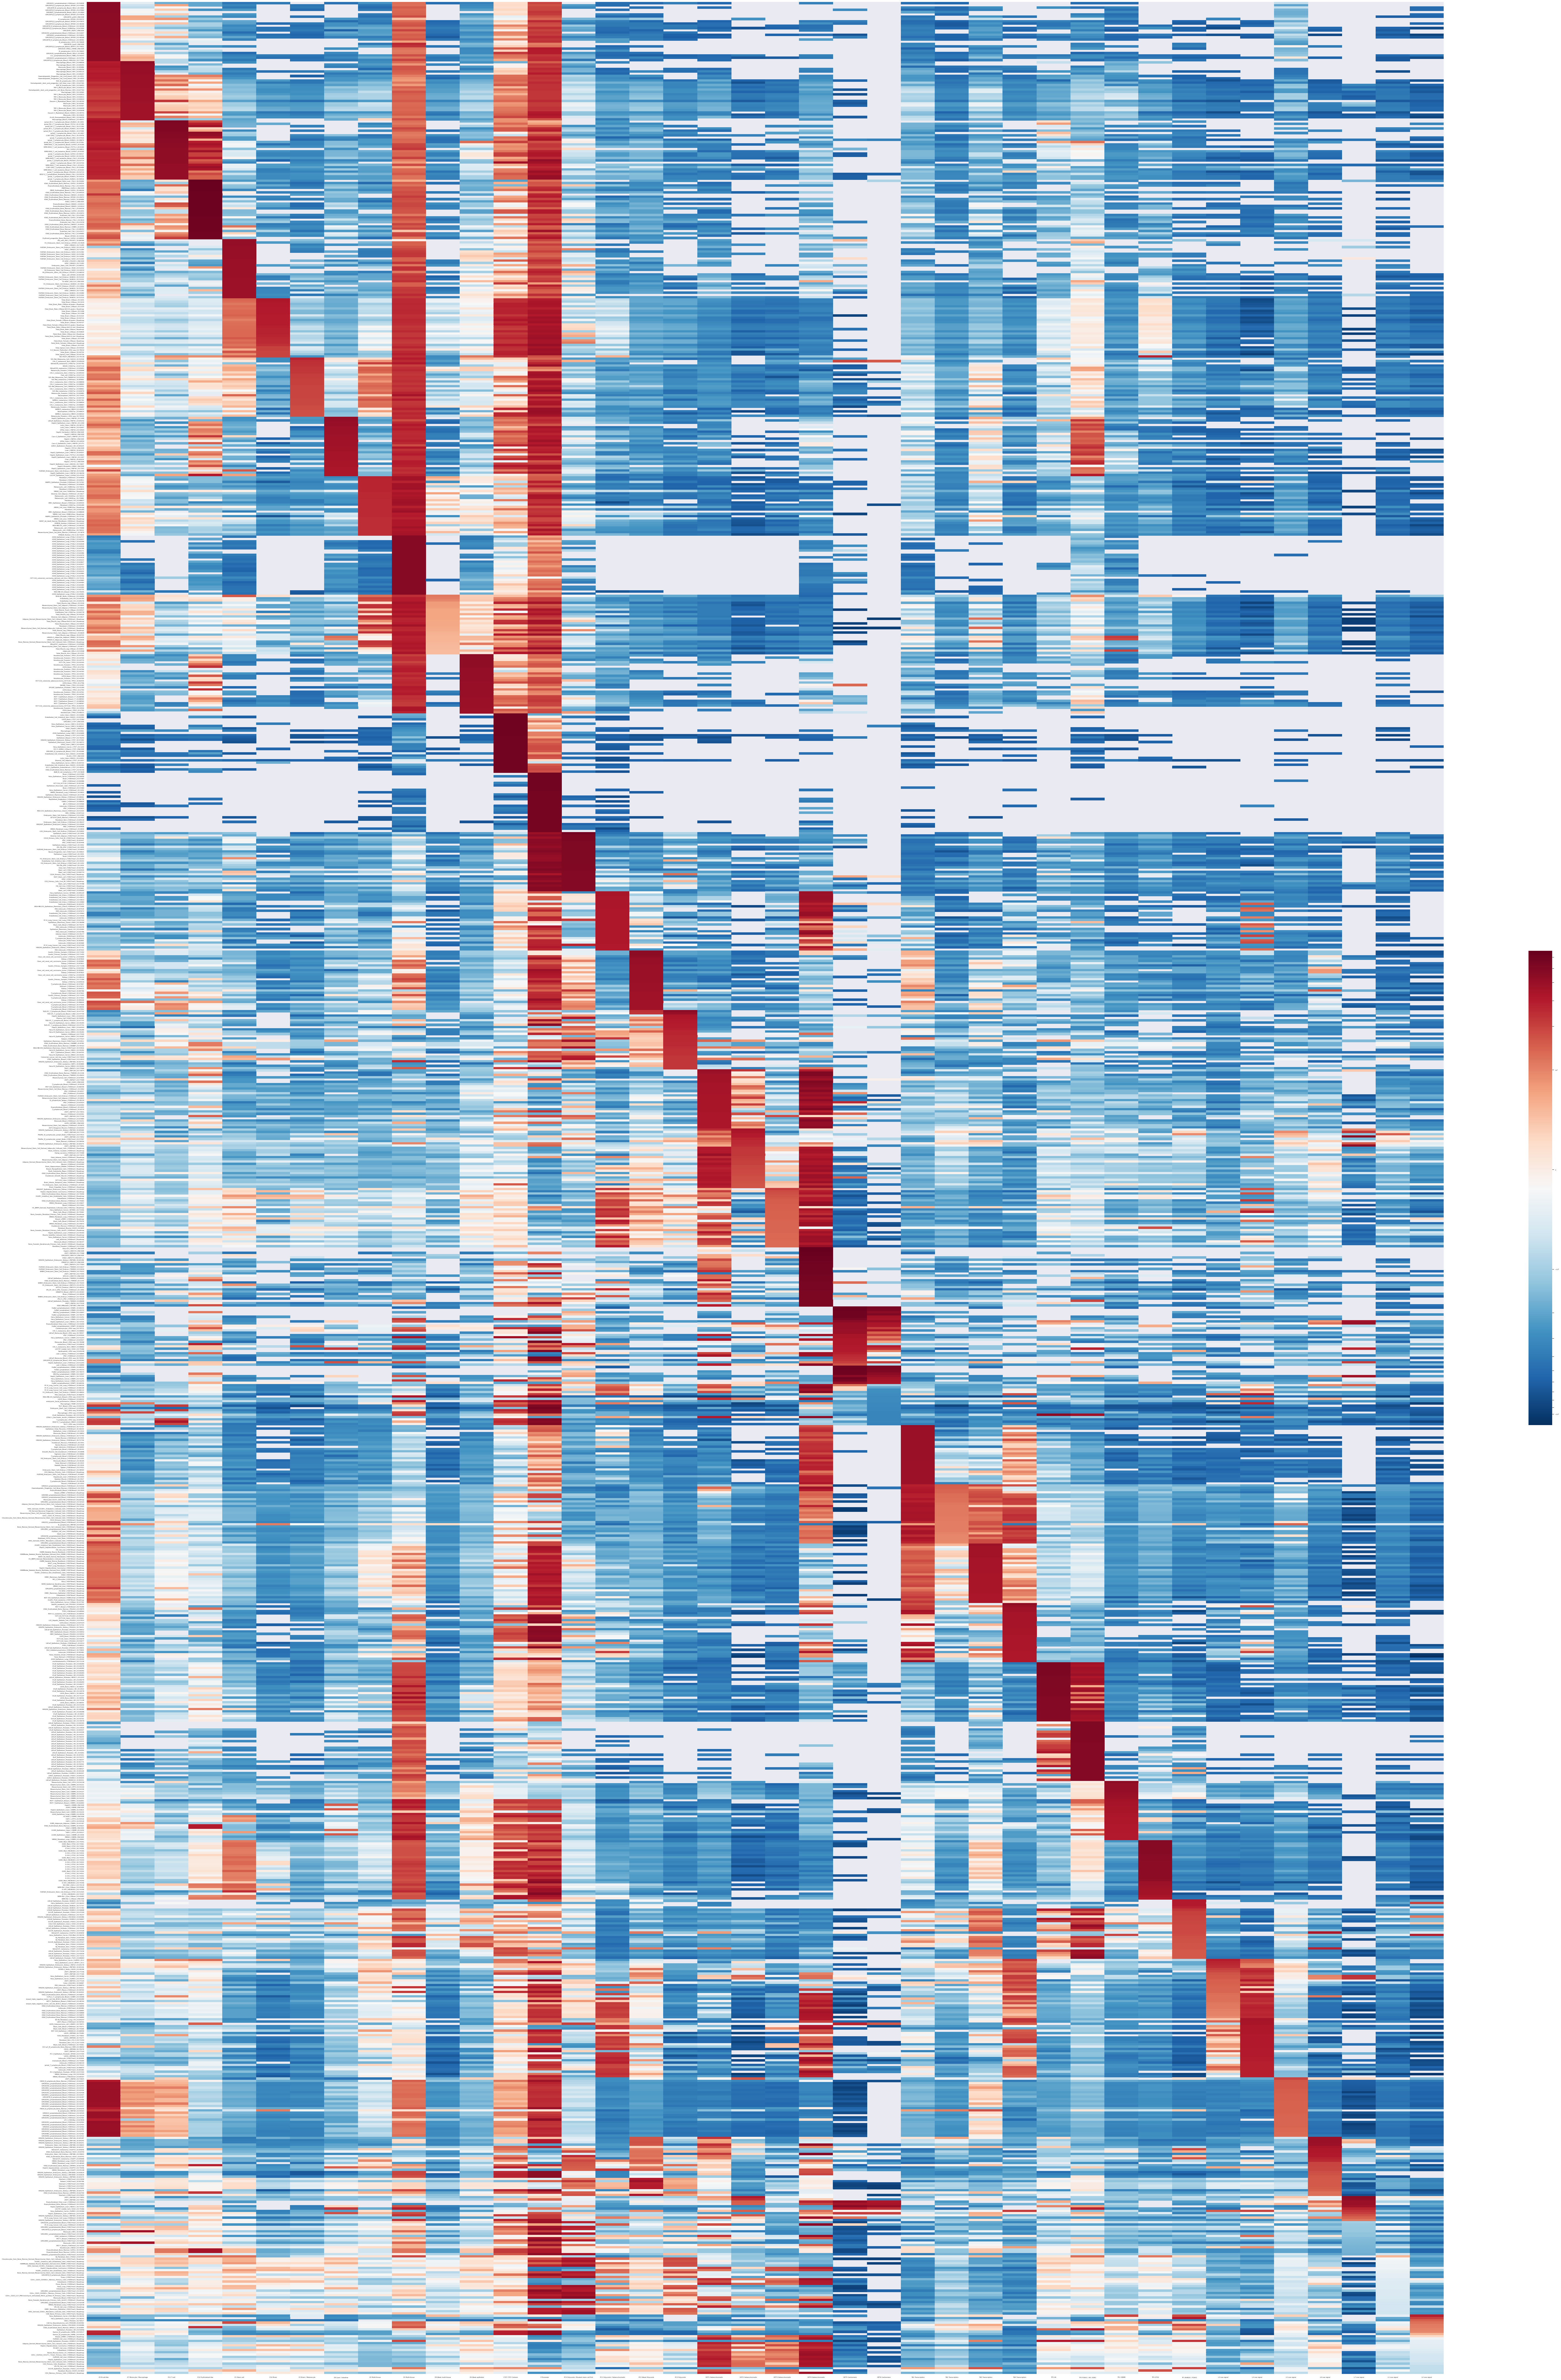

In [14]:
sns.set(font_scale=0.5)
fig = plt.figure(figsize=(90, 120))

sns.heatmap(
    data_df, annot=False, cmap='RdBu_r',
    xticklabels=1, yticklabels=1,
    norm=SymLogNorm(linthresh=1, linscale=1), vmin=-16, vmax=16,
    cbar_kws={'shrink': 0.2})
plt.tight_layout()
plt.savefig(
    os.path.join(FIGS_DIR, 'cistrome_track_enrichments.fishers.pdf'),
    dpi=300)